In [19]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

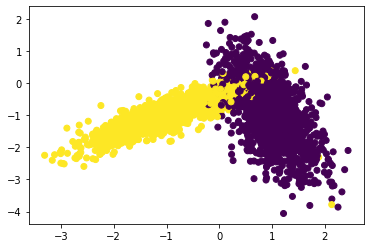

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

In [21]:
def RandomSearchCV(x_train, y_train, classifier, param_range, folds):
    
    trainscores = [] # train scores
    cvscores = [] # test/cross validation scores
    
    # choosing 10 random integers between param_range as params and sorting
    params = random.sample(range(param_range[0],param_range[1]),10)
    params.sort()
    
    # groups - dividing the numbers ranging from 0 to len(x_train) into groups
    # group_breaks - points at which the range 0 to len(x_train) must be broken
    group_breaks = [i for i in range(len(x_train)//folds,len(x_train)+1,len(x_train)//folds)]
    
    # list of tuples with starting and ending indices of each group 
    # [(start1,end1),(start2,end2)...]
    groups = []
    
    groups.append((0,group_breaks[0])) # first group - 0 to len(x_train)//folds
    
    for i in range(len(group_breaks)-2): # middle groups
        groups.append((group_breaks[i]+1,group_breaks[i+1]))
        
    # last group - last end index of the middle groups to len(x_train)
    groups.append((group_breaks[-2]+1,len(x_train)))
  
    for k in tqdm(params): # for each params
        trainscores_folds = []
        cvscores_folds = []
        for j in range(folds): # for each fold
            
            # cv_indeces holds indices of one group
            if j == folds-1: # if last fold no need to add one to range to handle index out of bounds error
                cv_indices = [i for i in range(groups[j][0],groups[j][1])]
            else:
                cv_indices = [i for i in range(groups[j][0],groups[j][1]+1)]
            
            # train_indices holds indices of other two groups
            train_indices = list(set(list(range(0, len(x_train)))) - set(cv_indices))
            
            # selecting the data points based on the train_indices and cv_indices
            X_train = x_train[train_indices]
            Y_train = y_train[train_indices]
            X_cv  = x_train[cv_indices]
            Y_cv  = y_train[cv_indices]
            
            # number of neighbours for knn
            classifier.n_neighbors = k
            
            # fit train data into classifier
            classifier.fit(X_train,Y_train)

            # predict for X_cv
            Y_predicted = classifier.predict(X_cv)
            
            # add accuracy score for each fold into cvscores_folds
            cvscores_folds.append(accuracy_score(Y_cv, Y_predicted))

            # predict for X_train
            Y_predicted = classifier.predict(X_train)
            
            # add accuracy scorefor each fold into trainscores_folds
            trainscores_folds.append(accuracy_score(Y_train, Y_predicted))
            
        trainscores.append(np.mean(np.array(trainscores_folds))) # add mean of trainscores
        cvscores.append(np.mean(np.array(cvscores_folds)))  # add mean of cvscores
        
    return trainscores, cvscores, params

100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


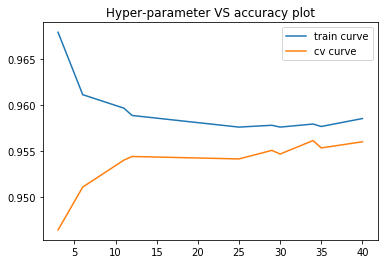

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

neigh = KNeighborsClassifier()
param_range = (1,50)
folds = 3

trainscores, cvscores, params = RandomSearchCV(X_train, y_train, neigh, param_range, folds)

plt.plot(params,trainscores,label = 'train curve')
plt.plot(params,cvscores,label = 'cv curve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

In [23]:
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

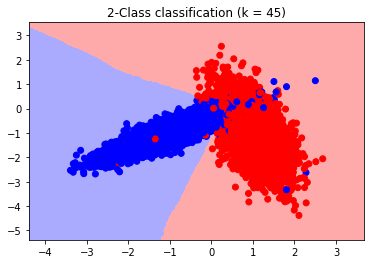

In [24]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 45)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)